In [621]:
import cv2
import numpy as np
import pandas as pd
from scipy.signal import convolve2d
from scipy.signal import correlate2d
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift

In [622]:
def bilinear_interpolation(image: np.array,scale_x:float,scale_y:float):
    old_height, old_width = image.shape
    M = int(scale_x * image.shape[0])
    N= int (scale_y*image.shape[1])
    row_scale = (old_height) / M
    col_scale = (old_width) / N
    
    resized_image = np.zeros((M, N), dtype=np.float32)

    for i in range(M):
        for j in range(N):
            i_old = i * row_scale
            j_old = j * col_scale
            
            x1 = int(np.floor(i_old))
            y1 = int(np.floor(j_old))
            x2 = min(x1 + 1, old_height - 1)
            y2 = min(y1 + 1, old_width - 1)
            
            f11 = image[x1, y1]
            f12 = image[x1, y2]
            f21 = image[x2, y1]
            f22 = image[x2, y2]
            
            d_i = i_old - x1
            d_j = j_old - y1
            
            linear1 = (1 - d_j) * f11 + d_j * f12
            linear2 = (1 - d_j) * f21 + d_j * f22
            
            resized_image[i, j] = (1 - d_i) * linear1 + d_i * linear2
    
    return resized_image
def gaussian_kernel_2D(size:int,sigma)->np.array:
    if(size % 2 ==0):
        raise("Enter odd value")
    x, y = np.meshgrid(np.arange(-(size//2), (size//2) + 1), np.arange(-(size//2), (size//2) + 1))
    kernel = np.exp( -0.5* (np.square(x) + np.square(y))/(np.square(sigma)))
    gaussian_kernel = kernel/np.sum(kernel)
    return gaussian_kernel
def blur_using_fft(image:np.array,kernel:np.array,intermediate=False)->np.array:
    image_shape = image.shape
    padded_image = np.pad(image,((image_shape[0]//2,image_shape[0]//2),(image_shape[1]//2,image_shape[1]//2)),mode='reflect')
    padded_kernel = np.zeros(padded_image.shape)
    padded_kernel[(padded_kernel.shape[0] // 2 - kernel.shape[0] // 2):(padded_kernel.shape[0] // 2 + kernel.shape[0] // 2 + 1), 
                  (padded_kernel.shape[1] // 2 - kernel.shape[1] // 2):(padded_kernel.shape[1] // 2 + kernel.shape[1] // 2 + 1)] = kernel
    padded_kernel = fftshift(padded_kernel)
    F_image = fft2(padded_image)
    F_kernel = fft2(padded_kernel)
    Image_filtered = F_image*F_kernel
    inversed = np.real(ifft2(Image_filtered))
    x,y = image_shape[0]//2,image_shape[1]//2
    out_image =inversed[x:x+image_shape[0],y:y+image_shape[1]]
    out_image =((out_image - np.min(out_image))/(np.max(out_image)-np.min(out_image)) *255).astype(np.uint8)
    return out_image.astype(np.uint8)

In [623]:
def notch_reject_filter_frequency(rows,cols, u, v, D0=10):
    u_shift = np.arange(cols) - cols//2
    v_shift = np.arange(rows) - rows//2
    X,Y = np.meshgrid(u_shift,v_shift)
    D_u_v = np.sqrt((X - u)**2 + (Y - v)**2)
    H = 1 - np.exp(-(D_u_v**2) / (2 * (D0**2)))
    return H

In [624]:
image_1 = cv2.imread("data/Q2_image1.png",cv2.IMREAD_ANYDEPTH)
if image_1.ndim == 3 and image_1.shape[-1] == 1:
    image_1 = image_1.squeeze(-1) 

In [625]:
scaling_x = 0.25
scaling_y = 0.25
sigma_x = 2+(scaling_x/np.pi)
sigma_y = 2+(scaling_y/np.pi)

aliased_image = bilinear_interpolation(image_1,scaling_x,scaling_y)
cv2.imwrite("output_images/Q2/alised_image.png",aliased_image,[cv2.IMWRITE_PNG_COMPRESSION,0])

True

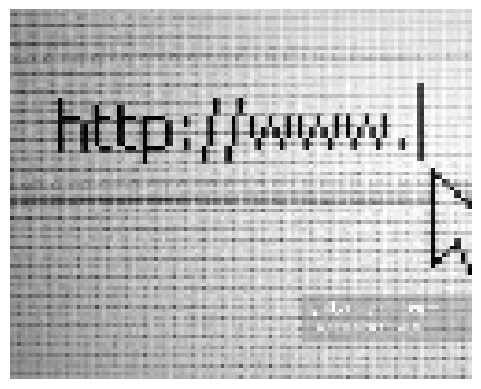

In [626]:
plt.imshow(aliased_image, cmap='gray')
plt.axis('off')
plt.show()


In [627]:
kernel = gaussian_kernel_2D(5,np.maximum(sigma_x,sigma_y))
filtered_image = blur_using_fft(image_1,kernel)
cv2.imwrite("output_images/Q2/filtered_image_spatial.png",filtered_image,[cv2.IMWRITE_PNG_COMPRESSION,0])
rescaled_image_after_filter = bilinear_interpolation(filtered_image,scaling_x,scaling_y)
cv2.imwrite("output_images/Q2/rescaled_image_after_filter.png",rescaled_image_after_filter,[cv2.IMWRITE_PNG_COMPRESSION,0])

True

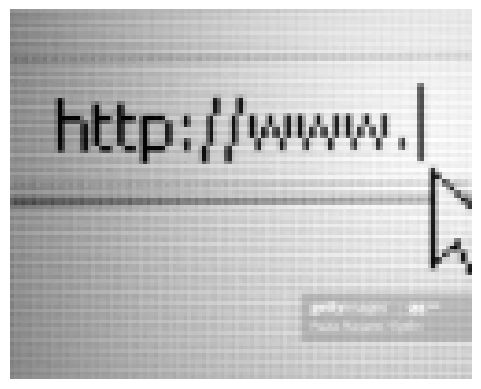

In [628]:
plt.imshow(rescaled_image_after_filter, cmap='gray')
plt.axis('off')
plt.show()


In [629]:
# image_1 = cv2.imread("data/myimage.jpg",cv2.IMREAD_ANYDEPTH)
# cv2.imwrite("data/Q2_image1.png",image_1)
# f_tranform = fft2(image_1)


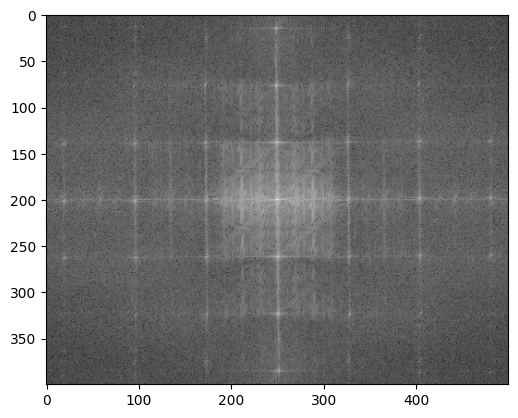

In [630]:
#************************************************************************Part C***************************************
# Part c
f_tranform = fft2(image_1)
shifted_transform = fftshift(f_tranform)
spectrum = np.log(np.abs(shifted_transform))
spectrum_display = 255*(spectrum -np.min(spectrum)/np.max(spectrum) - np.min(spectrum))
plt.imshow(spectrum_display, cmap='gray')
plt.axis('on')
plt.show()

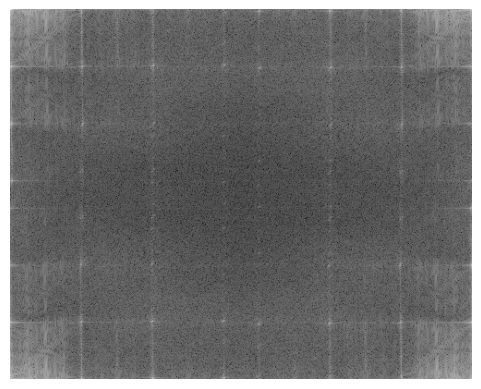

In [631]:
spectrum_without_shift = np.log(np.abs(f_tranform))
spectrum_display_without_shift = 255*(spectrum_without_shift -np.min(spectrum_without_shift)/np.max(spectrum_without_shift) - np.min(spectrum_without_shift))
plt.imshow(spectrum_display_without_shift, cmap='gray')
plt.axis('off')
plt.show()

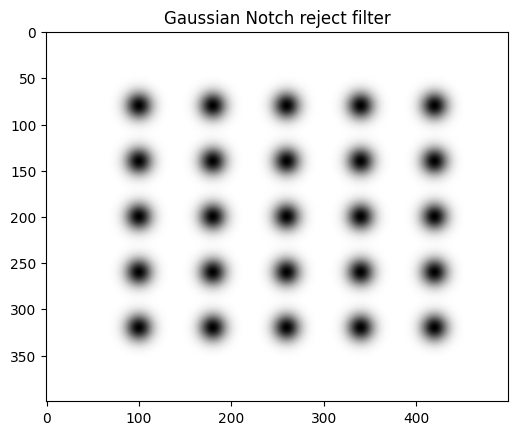

In [634]:
 

f_tranform = fft2(image_1)

spike_x = []
spike_y =[]
start_x = 80
start_y =  100
H = np.ones(f_tranform.shape)
for i in range(5):
    spike_x.append(start_x)
    spike_y.append(start_y)
    start_y += 80
    start_x += 60

def gaussian_notch(H, center, sigma):
    cx, cy = center
    for u in range(H.shape[0]):
        for v in range(H.shape[1]):
            distance = (u - cx)**2 + (v - cy)**2
            H[u, v] *= 1 - np.exp(-distance / (2 * sigma**2))
    return H

for x in spike_x:
    for y in spike_y:
     H = gaussian_notch(H, (x, y), 10)
plt.imshow(H, cmap='gray')
plt.title('Gaussian Notch reject filter')
plt.show()


In [635]:
G = f_tranform* H
g_filtered = np.abs(ifft2(ifftshift(G)))


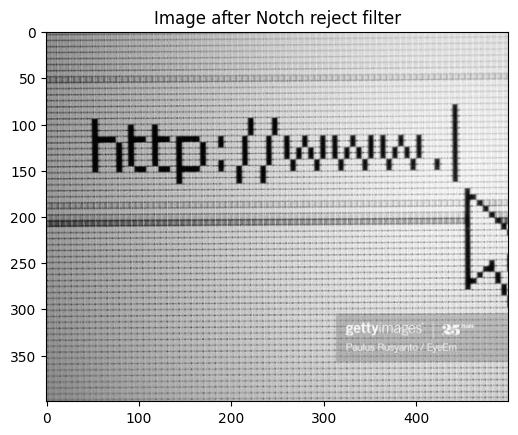

In [636]:
plt.imshow(g_filtered, cmap='gray')
plt.title('Image after Notch reject filter')
plt.show()

In [ ]:
#*******************Part D************************
#Optimum notch filter